# Optuna

[Хорошая статья на Хабре](https://habr.com/ru/post/704432/)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.9 MB/s eta 0:00:00


## Общий алгоритм работы с Optuna

1. Определяем целевую функцию `objective` , в через аргументы она будет получать специальный объект `trial`. С его помощью можно назначать различные гипермараметры, Например, как в примере выше, мы задаем x в интервале [-10,10].

2. Далее создаем объект обучения с помощью метода `optuna.create_study`.

3. Запускаем оптимизацию целевой функции objective на 10 итераций `n_trials=10`. Происходит 10 вызовов нашей функции с различными параметрами от -10 до 10. Какие именно параметры выбирает optuna будет описано ниже.

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_float('x', -10, 10)
    return (x - 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=10)

study.best_params 

[I 2023-02-17 11:03:20,446] A new study created in memory with name: no-name-6651dde1-0d2c-408b-895f-6d4194a76d8b
[I 2023-02-17 11:03:20,453] Trial 0 finished with value: 28.588930375786155 and parameters: {'x': 7.346861731500653}. Best is trial 0 with value: 28.588930375786155.
[I 2023-02-17 11:03:20,463] Trial 1 finished with value: 60.39316828429455 and parameters: {'x': 9.771304155950567}. Best is trial 0 with value: 28.588930375786155.
[I 2023-02-17 11:03:20,468] Trial 2 finished with value: 104.60733592076461 and parameters: {'x': -8.227772774204784}. Best is trial 0 with value: 28.588930375786155.
[I 2023-02-17 11:03:20,473] Trial 3 finished with value: 0.1770280598495278 and parameters: {'x': 1.5792529740455343}. Best is trial 3 with value: 0.1770280598495278.
[I 2023-02-17 11:03:20,485] Trial 4 finished with value: 42.170274727800425 and parameters: {'x': 8.493864390930906}. Best is trial 3 with value: 0.1770280598495278.
[I 2023-02-17 11:03:20,488] Trial 5 finished with value

{'x': 2.1665524643050382}

## Как задать пространство поиска гиперпараметров?

* `suggest_categorical(name, choice)` задает категориальные параметры
* `suggest_float(name, low, high, *, step=None, log=False)` задает параметр типа float - число с плавающей точкой
* `suggest_int(name, low, high, step=1, log=False)` задает параметр типа int - целое число

## Как посмотреть результаты оптимизации?

В объекте Study есть специальные поля, которые позволяют посмотреть результаты после обучения:
* `study.best_params` лучшие параметры
* `study.best_value`  лучшее оптимальное значение целевой функции
* `study.best_trial` развернутые параметры лучшего испытания

## Что под капотом?

* Samplers - это набор алгоритмов для поиска гиперпараметров.

* Pruners - это набор алгоритмов для прореживания экспериментов. Pruning - это механизм который позволяет обрывать эксперименты , которые с большой долей вероятности приведут к не оптимальным результатам.

## Sampler: Tree-structured Parzen Estimator (TPE)

Очень подробно - в [яндекс учебнике](https://academy.yandex.ru/handbook/ml/article/podbor-giperparametrov).

**Общая идея**: мы хотим чаще проверять гиперпраметры, близкие к тем, при которых модель показала хорошее качество на предыдущих попытках.


Предположим сначала, что мы хотим сделать поиск оптимального значения для одного гиперпараметра.

1. На нескольких первых итерациях алгоритму требуется «разогрев»: нужно иметь некоторую группу значений данного гиперпараметра, на которой известно качество модели. Самый простой способ собрать такие наблюдения — провести несколько итераций Random Search.

2. Следующим шагом будет разделение собранных во время разогрева данных на две группы. В первой группе будут те наблюдения, для которых модель продемонстрировала лучшее качество, а во второй — все остальные. Размер доли лучших наблюдений задаётся пользователем: чаще всего это 
10−25% от всех наблюдений:

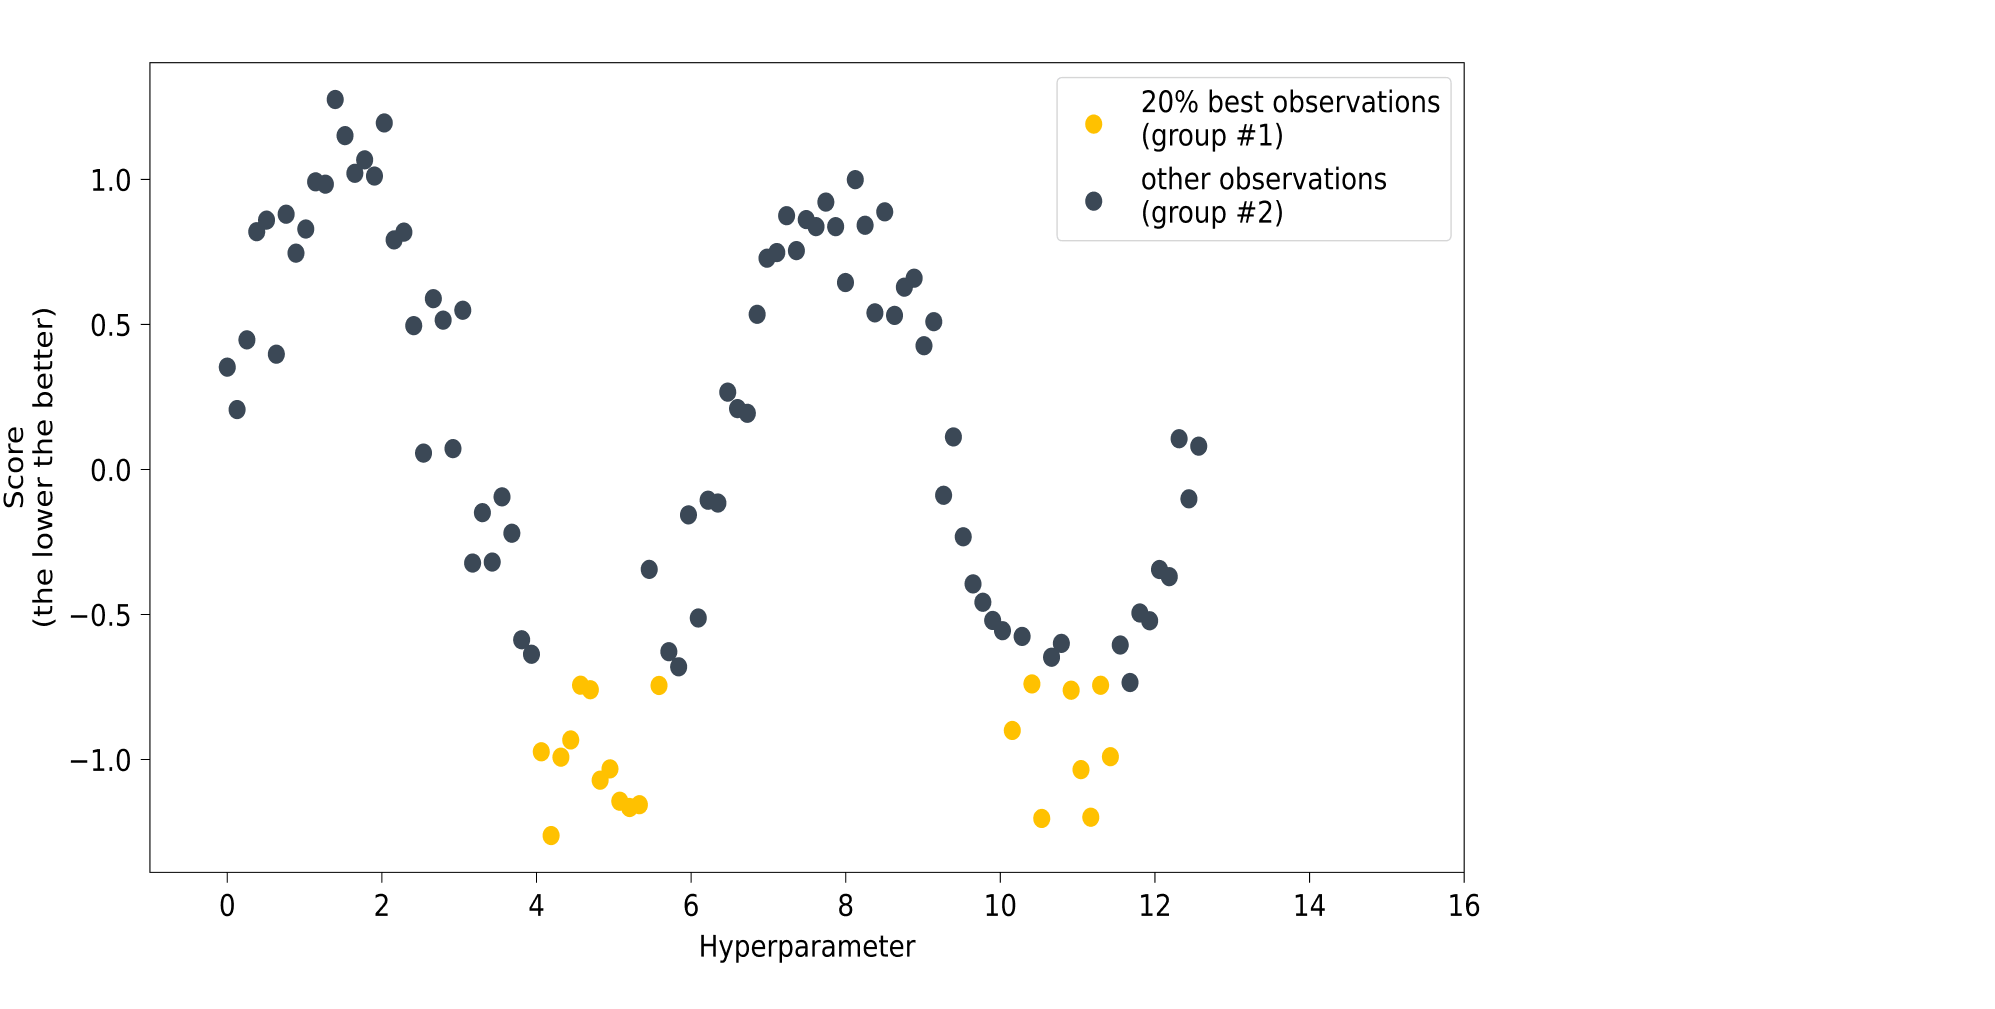

3. Далее некоторым образом строятся оценки распределения 
$l(x)$ лучших наблюдений и распределения $g(x)$ всех остальных в пространстве значений рассматриваемого гиперпараметра.

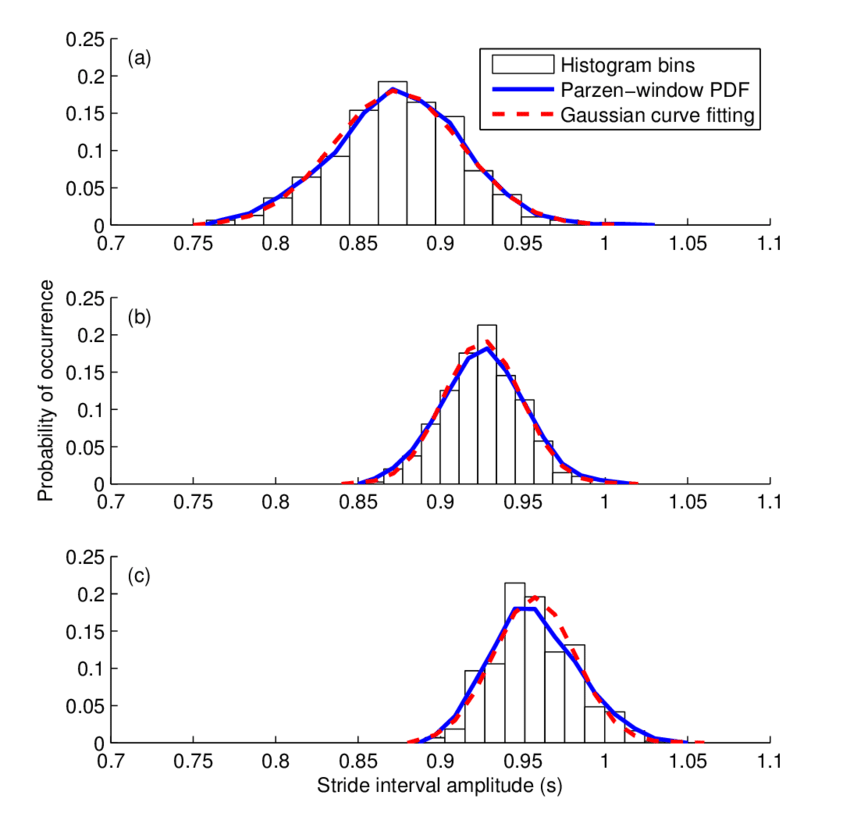

4. На следующем шаге алгоритма мы семплируем несколько значений-кандидатов из распределения $l(x)$. Из насемплированных кандидатов мы хотим найти тех, кто с большей вероятностью окажется в первой группе (состоящей из лучших наблюдений), чем во второй. Для этого для каждого кандидата $x$
вычисляется *Expected Improvement*: $$EI(x) = \frac{l(x)}{g(x)}$$:

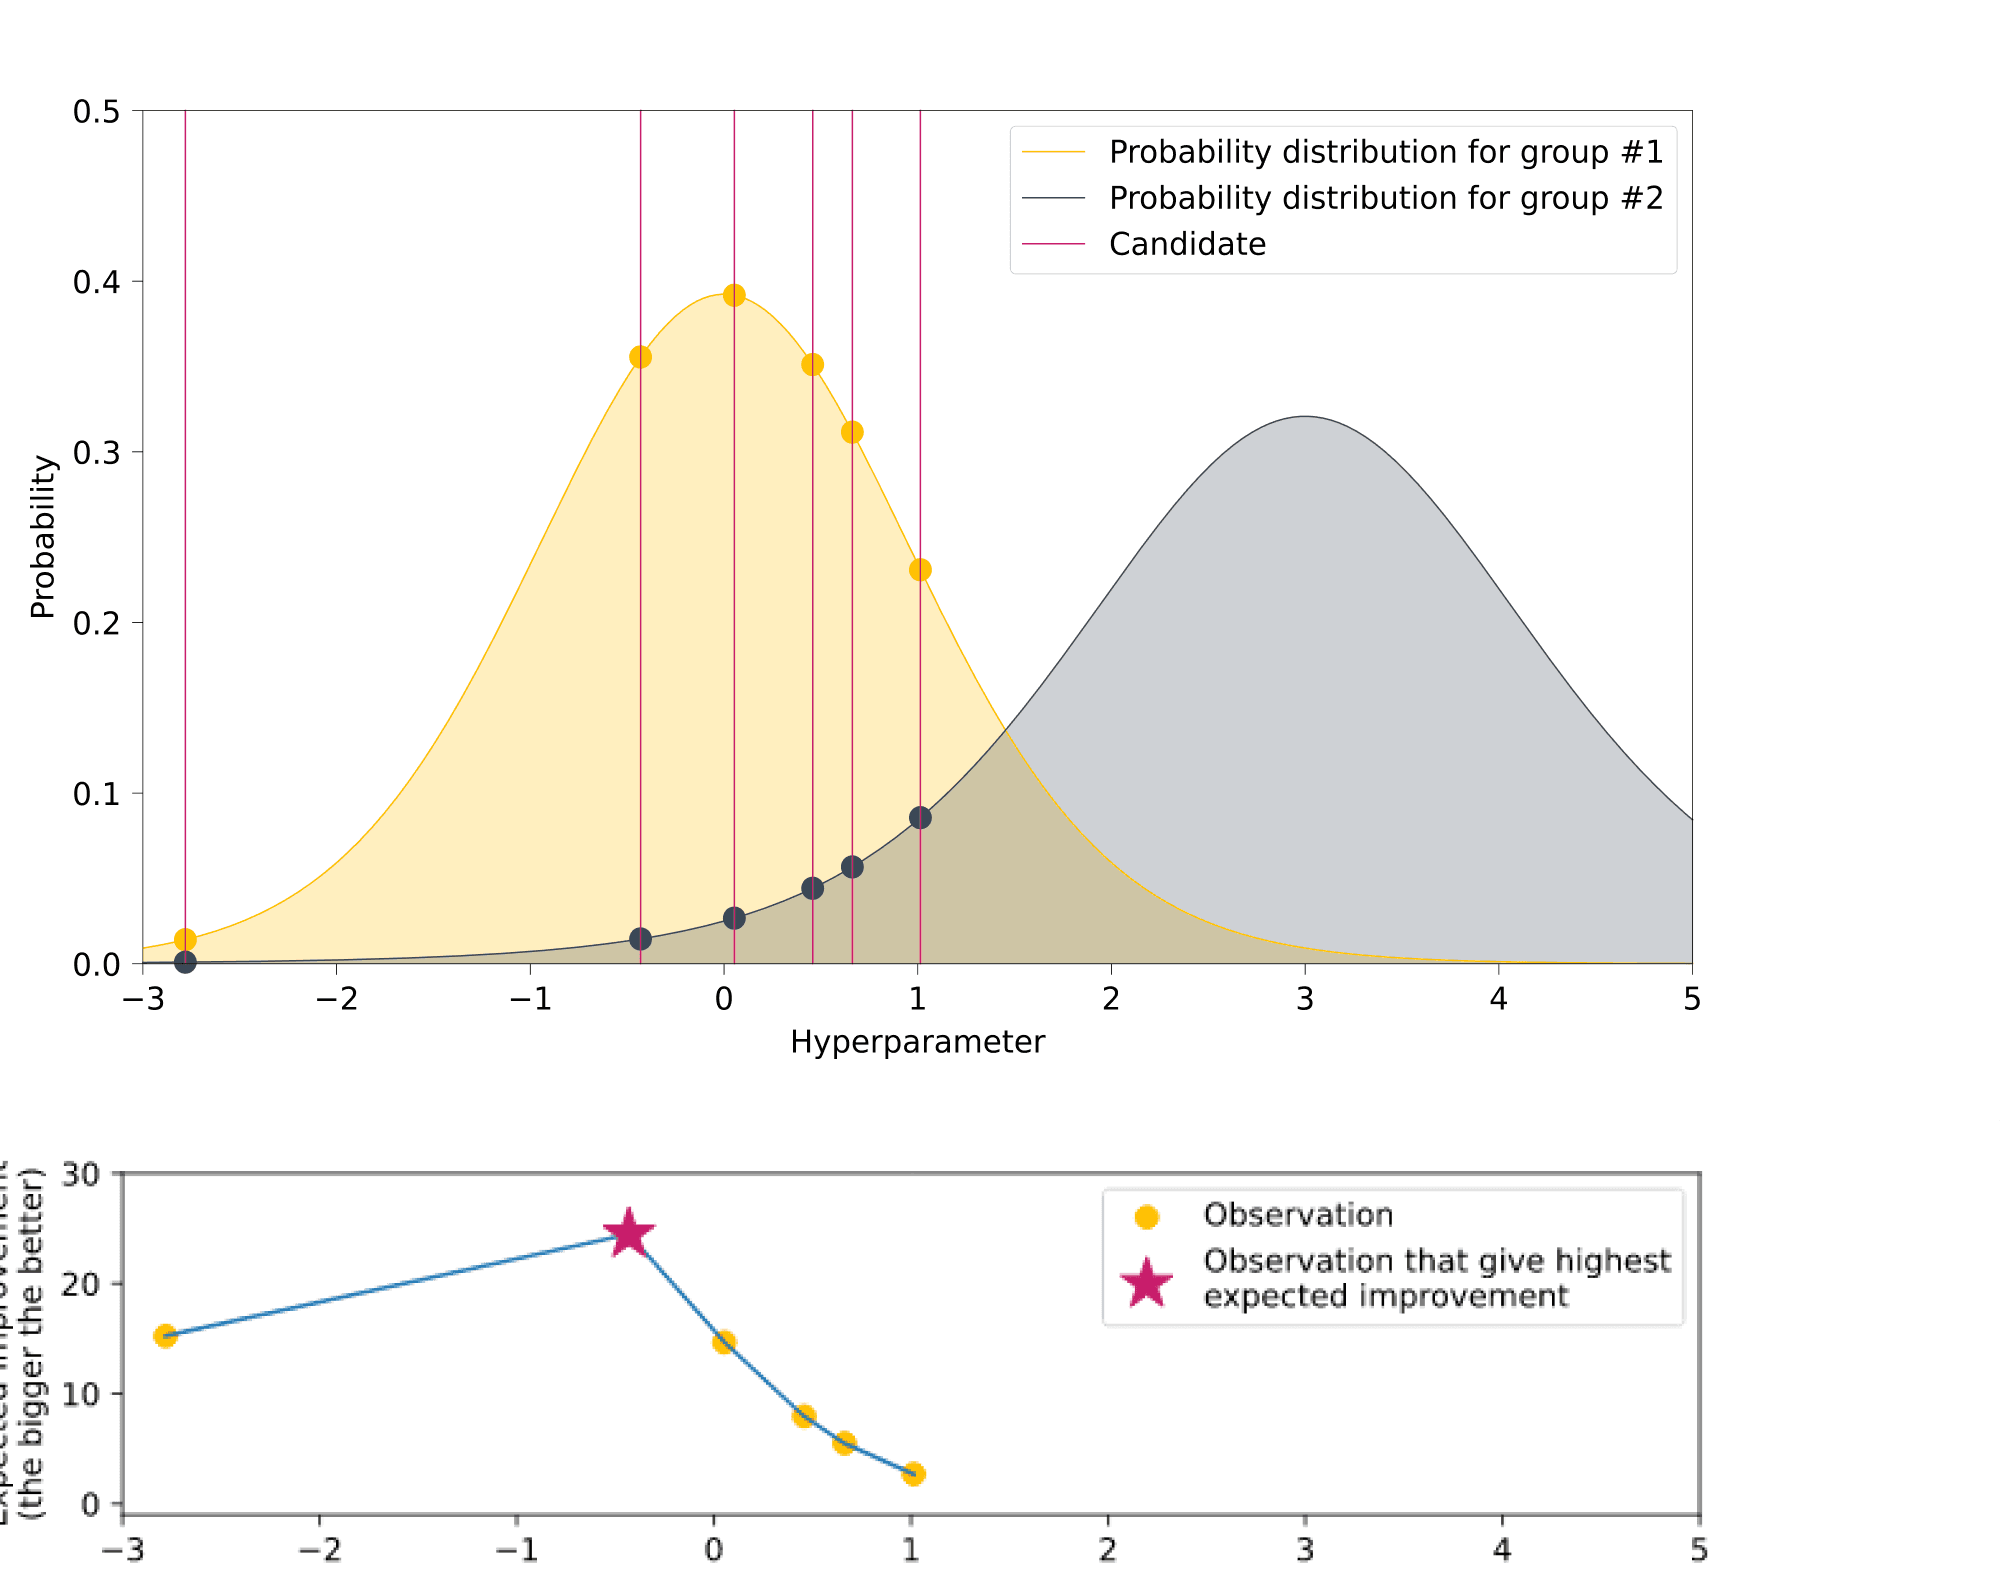

5. После того как было выбрано значение-кандидат, максимизирующее $EI$, обучается модель с этим значением гиперпараметра. 

После обучения мы замеряем её качество на валидационной выборке и в соответствии с этим результатом обновляем распределения $l(x)$ и $g(x)$: 
  * снова ранжируем всех имеющихся кандидатов по качеству модели с учётом последнего, из топ 10−25%
  * формируется обновлённое $l(x)$, из остальных — $g(x)$. 
Так происходит столько раз, сколько итераций алгоритма мы задали.

## Pruner: Median Pruner

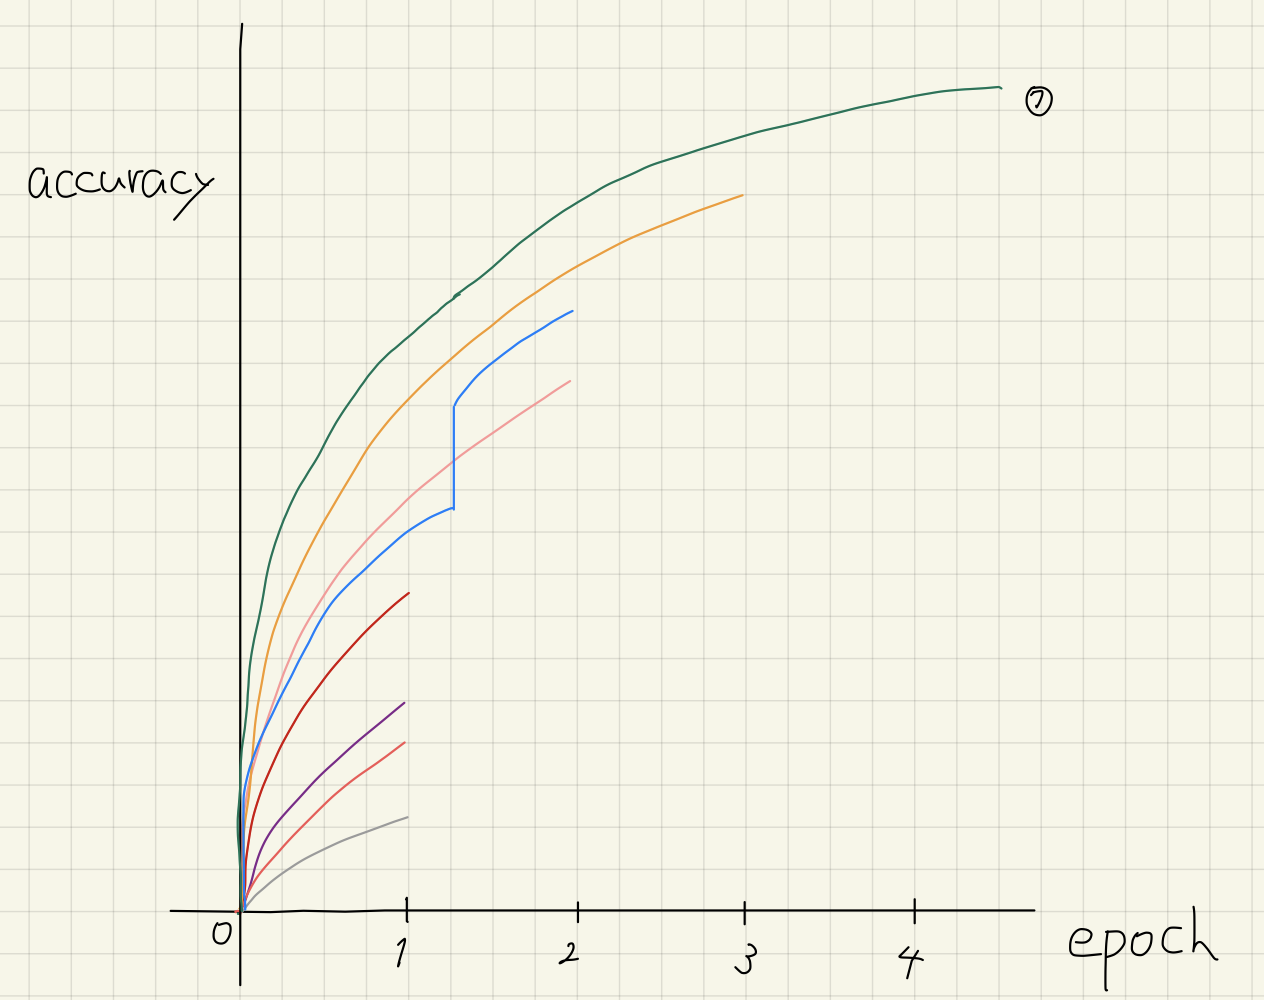

## Successive Halving Algorithm (SHA) of Pruning

* Optuna параллельно запускает несколько процессов поиска гиперпараметров (несколько trials)

* Периодически оцениваем learning curves этих процессов:
- изначально запускаем trials с минимальными ресурсами (мало обучающих примеров, мало итераций)
- на каждом следующем шаге отсекаем половину trials с худшим качеством + увеличиваем ресурсы

## Примеры

### Sklearn

In [6]:
import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm


def objective(trial):
    iris = sklearn.datasets.load_iris()
    x, y = iris.data, iris.target

    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=10
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-02-17 12:14:40,872] A new study created in memory with name: no-name-bd24b182-62f8-442f-9e77-425ab9676a69
[I 2023-02-17 12:14:40,940] Trial 0 finished with value: 0.96 and parameters: {'classifier': 'SVC', 'svc_c': 0.2001973511782666}. Best is trial 0 with value: 0.96.
[I 2023-02-17 12:14:41,095] Trial 1 finished with value: 0.9533333333333333 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 5}. Best is trial 0 with value: 0.96.
[I 2023-02-17 12:14:41,126] Trial 2 finished with value: 0.32 and parameters: {'classifier': 'SVC', 'svc_c': 1.47535929364147e-08}. Best is trial 0 with value: 0.96.
[I 2023-02-17 12:14:41,281] Trial 3 finished with value: 0.96 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 6}. Best is trial 0 with value: 0.96.
[I 2023-02-17 12:14:41,309] Trial 4 finished with value: 0.9733333333333333 and parameters: {'classifier': 'SVC', 'svc_c': 2.5394676109527485}. Best is trial 4 with value: 0.9733333333333333.
[I 2023-02-17 12:14:41,4

In [8]:
print(study.best_trial)

FrozenTrial(number=36, state=TrialState.COMPLETE, values=[0.9866666666666667], datetime_start=datetime.datetime(2023, 2, 17, 12, 14, 44, 62386), datetime_complete=datetime.datetime(2023, 2, 17, 12, 14, 44, 114796), params={'classifier': 'SVC', 'svc_c': 4.277452536117732}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'svc_c': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None)}, trial_id=36, value=None)


In [9]:
study.best_value

0.9866666666666667

In [10]:
study.best_params

{'classifier': 'SVC', 'svc_c': 4.277452536117732}

### CatBoost

In [13]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.2 MB/s eta 0:00:00


In [15]:
import numpy as np
import optuna

import catboost as cb
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def objective_cb(trial):
    data, target = load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_cb, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-02-17 12:19:44,917] A new study created in memory with name: no-name-22af8266-00f4-461a-8bd1-e5a5afe887f1
[I 2023-02-17 12:19:45,533] Trial 0 finished with value: 0.9766081871345029 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.022633384816385098, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8079688686868112}. Best is trial 0 with value: 0.9766081871345029.
[I 2023-02-17 12:19:46,338] Trial 1 finished with value: 0.9649122807017544 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08258651488161899, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9766081871345029.
[I 2023-02-17 12:19:46,899] Trial 2 finished with value: 0.9766081871345029 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.01896091791864624, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.819197068878243}. Best is trial 0 with value:

Number of finished trials: 100
Best trial:
  Value: 1.0
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.0920970814411136
    depth: 9
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.9957855641899845
